## Пункт 3: учёт ограничения на угловую скорость

В этом ноутбуке решается задача оптимизации для определения ориентации, подходящей под органичение на угловую скорость. Исходя из результатов можно утверждать, что такие ограничения срабатывают для орбит с околонулевой долготой восходящего узла (отсчитывается относительно оси Х инерциальной системы)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from orientation_handler import SpacecraftOrientationHandler
from orbital_handler import OrbitalFrameOrientationHandler
from optimizer import OptimizeSpacecraftOrientation

Задаем параметры плоскости орбиты КА и большую полуось (остальное определяется из того, что орбита круговая)

In [3]:
def calc_inclunation(theta, raan):
    """
    Расчет наклонения полярной орбиты в инерциальной системе XYZ
    theta: угол между проекцией Земной оси на плоскость XY и направлением на Солнце (осью Х)
    raan: ДВУ орбиты в инерциальной системе
    """
    alpha = (90 - 23.44) / 180 * np.pi
    return np.pi / 2 - np.abs(np.arctan(np.sin(theta - raan) / np.tan(alpha)))

In [4]:
mu = 398600.4415                               
a = 6371 + 800                                 
Omega = 0 * np.pi / 400
i = calc_inclunation(theta=np.pi/4 , raan=Omega)

print("Наклонение орбиты: ", np.round(i * 180 / np.pi, 2), "градусов")
print("Долгота восходящего узла: ", np.round(Omega * 180 / np.pi, 2), "градусов")

Наклонение орбиты:  72.96 градусов
Долгота восходящего узла:  0.0 градусов


In [5]:
spacefraft_orientation = SpacecraftOrientationHandler(a, i, Omega, mu)
orbital_frame_orientation = OrbitalFrameOrientationHandler(a, i, Omega)

In [6]:
# Задаём параметризацию
def phi(u, w):
    return w[2] * np.arctan(w[0] * np.sin(u) + w[1] * np.cos(u))

def phi_der(u, w):
    return w[2] * (w[0] * np.cos(u) - w[1] * np.sin(u)) / (1 + (w[0] * np.sin(u) + w[1] * np.cos(u))**2)

In [7]:
# Расчитываем ограничение на угловую скорость
angular_velocity_constraint = np.pi / 180
phi_dot_constraint = np.sqrt( angular_velocity_constraint**2 / spacefraft_orientation.n**2 - 1)

print("Суммарное ограничение:", angular_velocity_constraint)
print("Среднее движение:", spacefraft_orientation.n)
print(r"Ограничение на $\varphi^\prime_u$:", phi_dot_constraint)

Суммарное ограничение: 0.017453292519943295
Среднее движение: 0.0010396790766118743
Ограничение на $\varphi^\prime_u$: 16.75738115205302


In [8]:
optimizer = OptimizeSpacecraftOrientation(spacefraft_orientation.illuminance, phi_dot_constraint)
result = optimizer.optimize(phi, phi_der)

Произодная оптимального решения обращается в бесконечность


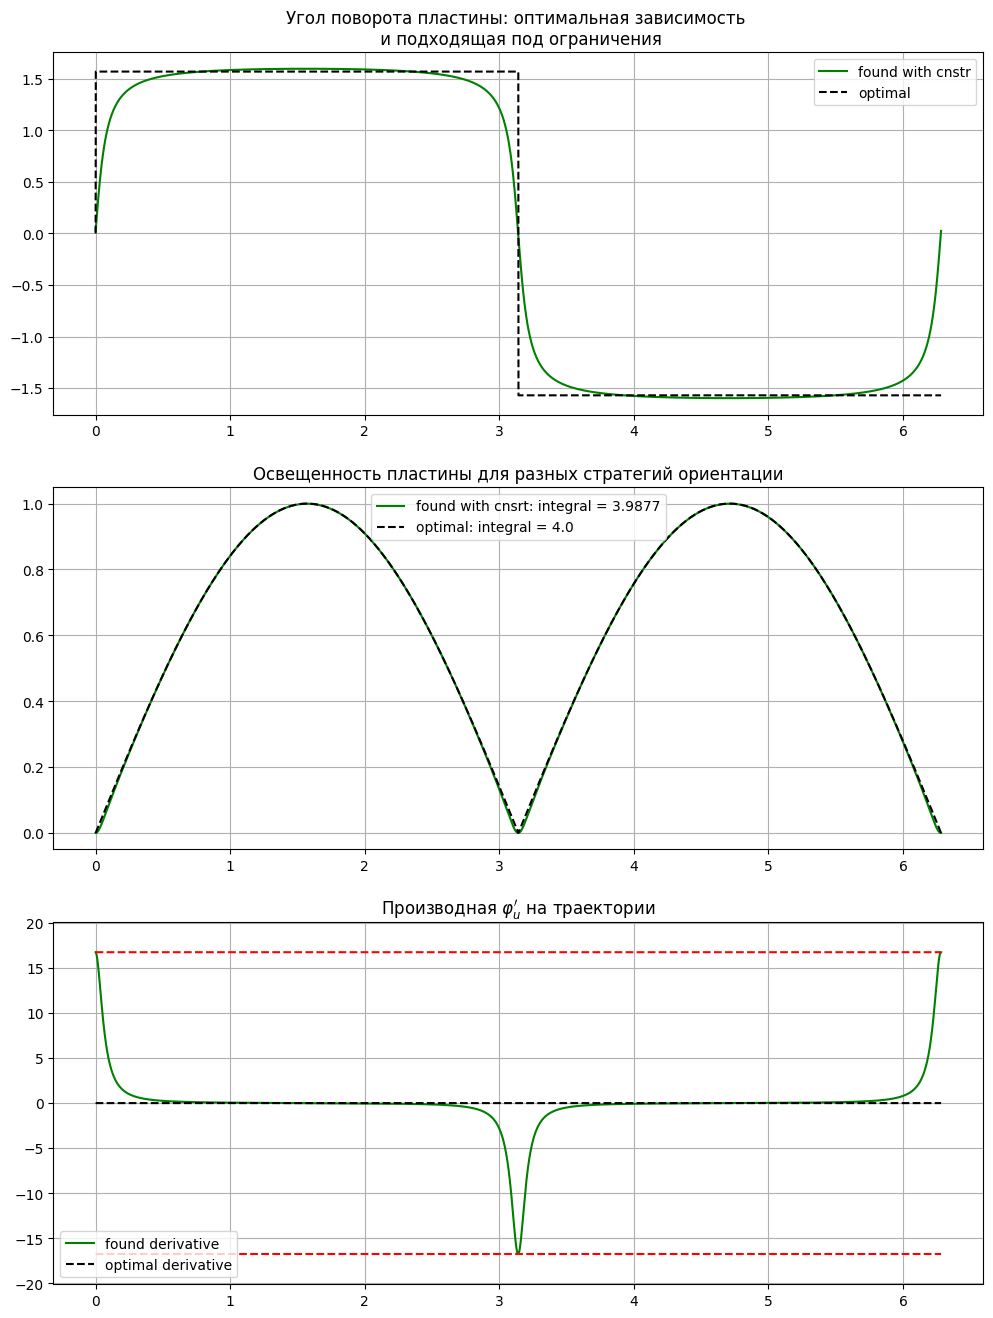

In [9]:
u_s = np.linspace(0, 2 * np.pi, 10000)
phi_opt = spacefraft_orientation.optimal_phi(u_s)
phi_found = phi(u_s, result.x)

fig, ax = plt.subplots(nrows=3, figsize=(12, 16))

ax[0].plot(u_s, phi_found, 'g-', label='found with cnstr')
ax[0].plot(u_s, phi_opt, '--', color='black', label='optimal')
ax[0].legend()
ax[0].grid(True)
ax[0].set_title("Угол поворота пластины: оптимальная зависимость \n и подходящая под ограничения")

# Расчет целевого интеграла от освещённости на траектории
ill_opt_int = np.sum(spacefraft_orientation.illuminance(u_s, phi_opt) * (u_s[1] - u_s[0]))
ill_found_int = np.sum(spacefraft_orientation.illuminance(u_s, phi_found) * (u_s[1] - u_s[0]))

ax[1].plot(u_s, spacefraft_orientation.illuminance(u_s, phi_found), 'g-', label=f'found with cnsrt: integral = {np.round(ill_found_int, 4)}')
ax[1].plot(u_s, spacefraft_orientation.illuminance(u_s, phi_opt), '--', color='black', label=f'optimal: integral = {np.round(ill_opt_int, 4)}')
ax[1].legend()
ax[1].grid(True)
ax[1].set_title("Освещенность пластины для разных стратегий ориентации")

ax[2].plot(u_s, phi_der(u_s, result.x),'g-', label='found derivative')
ax[2].plot(u_s, spacefraft_orientation.derivative_of_optimal_phi(u_s), '--', color="black", label='optimal derivative')
ax[2].plot(u_s, np.ones_like(u_s) * optimizer.cnstr, 'r--')
ax[2].plot(u_s, np.ones_like(u_s) * -optimizer.cnstr, 'r--')
ax[2].set_ylim([np.min(phi_der(u_s, result.x)) * 1.2, np.max(phi_der(u_s, result.x)) * 1.2])
ax[2].grid(True)
ax[2].set_title(r"Производная $\varphi^\prime_u$ на траектории")
ax[2].legend()

plt.show()